# INF250 - Assignment 2

In [36]:
import skimage
from skimage import io, color, filters, feature, measure, morphology
import numpy as np
import matplotlib.pyplot as plt

/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_11627/1691170106.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(image);


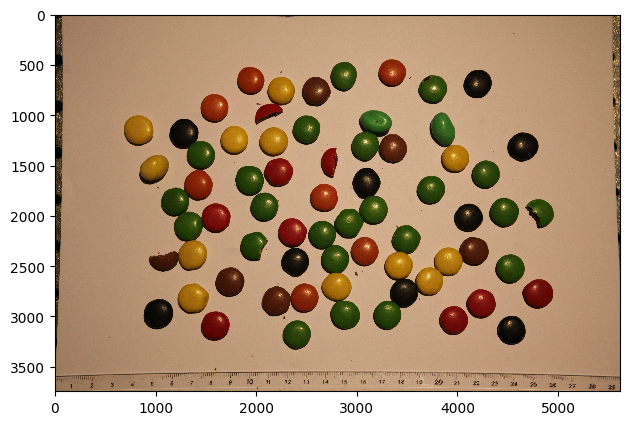

In [37]:
image = skimage.io.imread("IMG_2754_nonstop_alltogether.JPG")
skimage.io.imshow(image);

In [38]:
import skimage.color

# Fix weird 2-channel or RGBA images
if image.ndim == 2:
    image = skimage.color.gray2rgb(image)
elif image.shape[2] == 4:  # RGBA -> RGB
    image = skimage.color.rgba2rgb(image)
elif image.shape[2] == 2:  # Gray + Alpha -> just use first channel
    image = skimage.color.gray2rgb(image[..., 0])


/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_11627/2563508896.py:12: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(blurred_image);


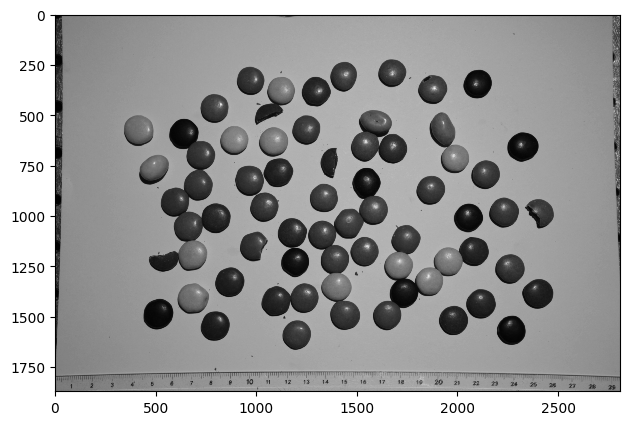

In [39]:
SCALE = 0.5

# Convert the image to grayscale
gray_image = skimage.color.rgb2gray(image)

small_image = skimage.transform.rescale(gray_image, SCALE, anti_aliasing=True)

# Reduce the noise in the image with gaussian filter
blurred_image = skimage.filters.gaussian(small_image, sigma=1)

# Display the processed images
skimage.io.imshow(blurred_image);

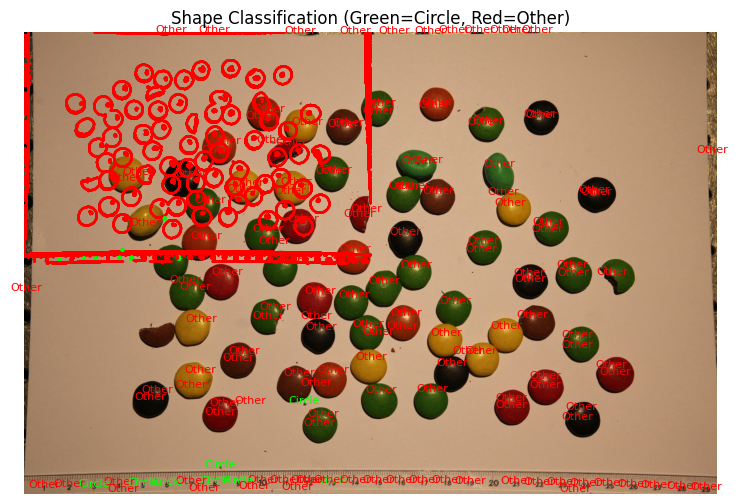

In [ ]:
# Detect edges using the Canny edge detector
edges = skimage.feature.canny(blurred_image, sigma=1)

filled = morphology.remove_small_holes(edges, area_threshold=100)
filled = morphology.binary_closing(filled, morphology.disk(3))

labels = measure.label(filled)
regions = measure.regionprops(labels)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image)

for region in regions:
    area = region.area
    perimeter = region.perimeter
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * area / (perimeter ** 2)
    
    if area < 100:
        continue

    y, x = np.array(region.centroid) / SCALE

    if circularity > 0.7:
        color_ = 'lime'
        label = "Circle"
    else:
        color_ = 'red'
        label = "Other"
    
    for coords in region.coords:
        ax.plot(coords[1], coords[0], '.', color=color_, markersize=0.5)
    ax.text(x, y, label, color=color_, fontsize=8, ha='center')

ax.set_title("Shape Classification (Green=Circle, Red=Other)")
ax.axis('off')
plt.show()
